# Myers Briggs Personality Data from Social Media

In [182]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import xgboost as xgb
import spacy
from collections import Counter

In [31]:
df= pd.rea_csv('./data/mbit_clean_split.csv')
balanced_df= df.groupby('type',as_index = False,group_keys=False).apply(lambda s: s.sample(1000,replace=True))
balanced_df.to_csv('./data/mbti_random_samples.csv')

In [37]:
df = pd.read_csv('./data/mbti_random_samples.csv', index_col=0)
df = df[df.length > 20]
df['EoI'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['SoN'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['ToF'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df['JoP'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
df.head()

type                                              posts  length  EoI  \
5245    ENFJ  how are old are you where are you from bay are...      28    1   
359533  ENFJ  lol that s the one question of yours that i wa...      41    1   
335964  ENFJ  i don t mind being alone as this when i am abl...      43    1   
178035  ENFJ  i ve had my fair share of people loving me lol...      31    1   
409468  ENFJ  hello there my hun has been victim of sexual h...      38    1   

        SoN  ToF  JoP  
5245      0    0    1  
359533    0    0    1  
335964    0    0    1  
178035    0    0    1  
409468    0    0    1

In [38]:
print("Number of rows: ", len(df))

Number of rows:  16000


In [39]:
df['length'] = [len(x.split()) for x in df.posts]

# General Data Distribution

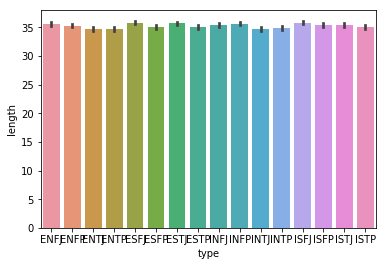

In [40]:
# df['type'] = df.index
sns.barplot(x ='type', y ='length', data=df)

# Class distribution (cleaned and sub-sampled for balanced number of examples)

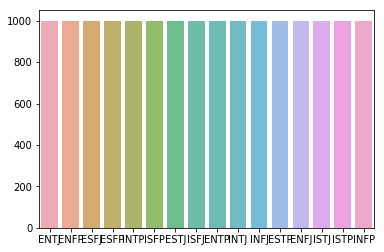

In [41]:
cnt_srs = df['type'].value_counts()

sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)

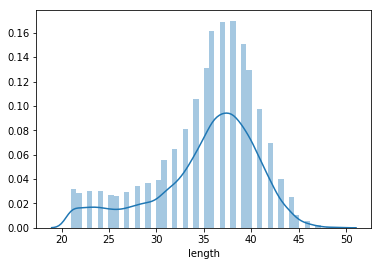

In [120]:
sns.distplot(df.length)

df['question_per_comment'] = df['posts'].apply(lambda x: x.count('?')/50)
df['excl_per_comment'] = df['posts'].apply(lambda x: x.count('!')/50)
df['ellipsis_per_comment'] = df['posts'].apply(lambda x: x.count('...')/50)


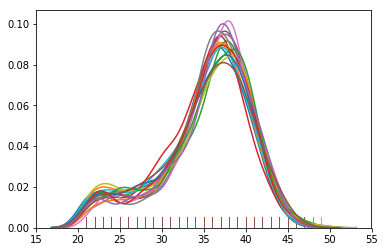

In [121]:
labels = set(df.type)
targets = [df.loc[df['type'] == val] for val in labels]

# Iterate through list and plot the sliced dataframe
for target in targets:
    sns.distplot(target[['length']], hist=False, rug=True)

plt.show()

In [46]:
df.length.describe()

count    16000.000000
mean        35.283125
std          5.469743
min         21.000000
25%         33.000000
50%         36.000000
75%         39.000000
max         49.000000
Name: length, dtype: float64

In [47]:

list_posts= df.posts
cntizer = CountVectorizer(analyzer="word",tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
#                             ngram_range=(1,1),
                             max_df=0.5,
                             min_df=0.1) 
                                 
tfizer = TfidfTransformer()

print("CountVectorizer")
X_cnt = cntizer.fit_transform(list_posts)
print("Tf-idf")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()

CountVectorizer
Tf-idf


In [161]:
y_one_hot = np.zeros((len(df), len(labels)))
label_to_int={k:i for i,k in enumerate(labels)}
for i,y in enumerate(df.type):
    y_one_hot[i][label_to_int[y]] = 1
    

In [48]:

# Truncated SVD
svd = TruncatedSVD(n_components=12, n_iter=10, random_state=42)
svd_vec = svd.fit_transform(X_tfidf)


# Tsne to check sepratability

In [111]:

print("TSNE")
X_tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500).fit_transform(svd_vec)

TSNE
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16000 samples in 0.008s...
[t-SNE] Computed neighbors for 16000 samples in 5.728s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16000
[t-SNE] Computed conditional probabilities for sample 2000 / 16000
[t-SNE] Computed conditional probabilities for sample 3000 / 16000
[t-SNE] Computed conditional probabilities for sample 4000 / 16000
[t-SNE] Computed conditional probabilities for sample 5000 / 16000
[t-SNE] Computed conditional probabilities for sample 6000 / 16000
[t-SNE] Computed conditional probabilities for sample 7000 / 16000
[t-SNE] Computed conditional probabilities for sample 8000 / 16000
[t-SNE] Computed conditional probabilities for sample 9000 / 16000
[t-SNE] Computed conditional probabilities for sample 10000 / 16000
[t-SNE] Computed conditional probabilities for sample 11000 / 16000
[t-SNE] Computed conditional probabilities for sample 12000 / 16000
[t-SNE] Computed conditional probabilities f

In [84]:
lab_encoder = LabelEncoder().fit(list(labels))
list_personality =[]
for row in df.iterrows():
    type_labelized = lab_encoder.transform([row[1].type])[0]
    list_personality.append(type_labelized)

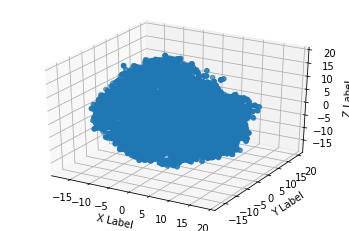

In [79]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = X_tsne[:,0]
y = X_tsne[:,1]
z = X_tsne[:,2]

ax.scatter(x, y, z, marker='o', cmap=plt.get_cmap('tab20'))


plt.show()

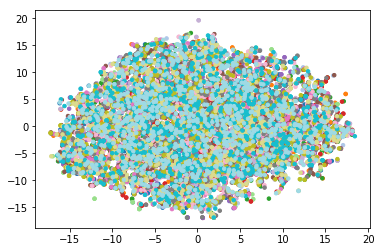

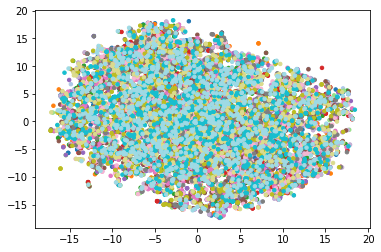

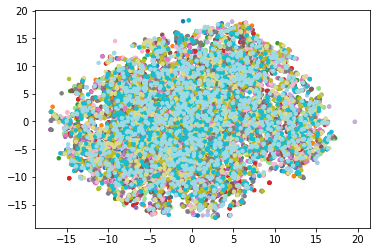

In [86]:
col = list_personality
plt.figure(0)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.figure(1)
plt.scatter(X_tsne[:,0], X_tsne[:,2], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.figure(2)
plt.scatter(X_tsne[:,1], X_tsne[:,2], c=col, cmap=plt.get_cmap('tab20') , s=12)


In [106]:
titles = ["Extraversion (E) - Introversion (I)",
          "Sensation (S) - INtuition (N)",
          "Thinking (T) - Feeling (F)",
          "Judgement (J) - Perception (P)"
         ] 
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    return [b_Pers[l] for l in personality]

def translate_back(personality):

    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in df.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

# Plot
def plot_tsne(X, i):
    a = plt.figure(i, figsize=(30,20))
    plt.title(titles[i])
    plt.subplot(3,1,1)
    plt.scatter(X[:,0], X[:,1], c=list_personality_bin[:,i], cmap=plt.get_cmap('Dark2'), s=25)
    plt.subplot(3,1,2)
    plt.scatter(X[:,0], X[:,2], c=list_personality_bin[:,i], cmap=plt.get_cmap('Dark2'), s=25)
    plt.subplot(3,1,3)
    plt.scatter(X[:,1], X[:,2], c=list_personality_bin[:,i], cmap=plt.get_cmap('Dark2'), s=25)

Binarize MBTI list: 
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 1 1 1]
 [0 1 1 1]
 [0 1 1 1]]


# E - I

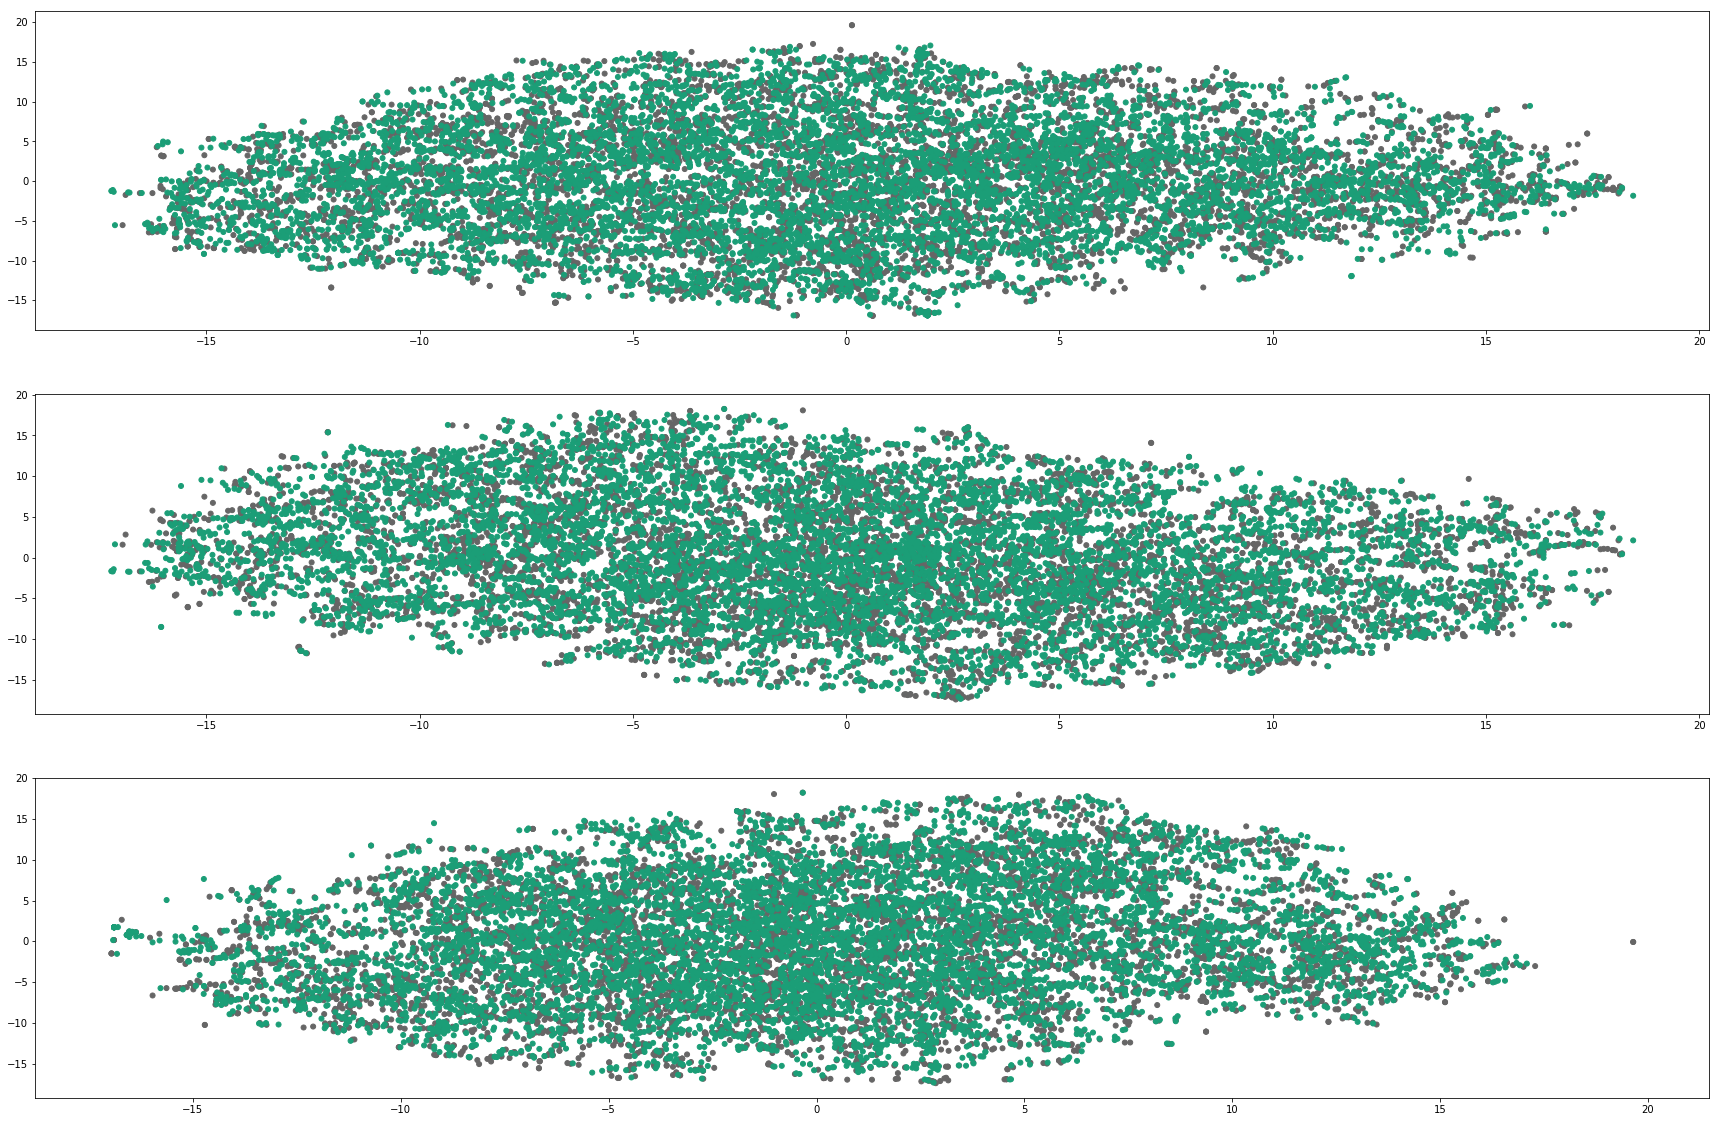

In [107]:
plot_tsne(X_tsne, 0 )

# S - N

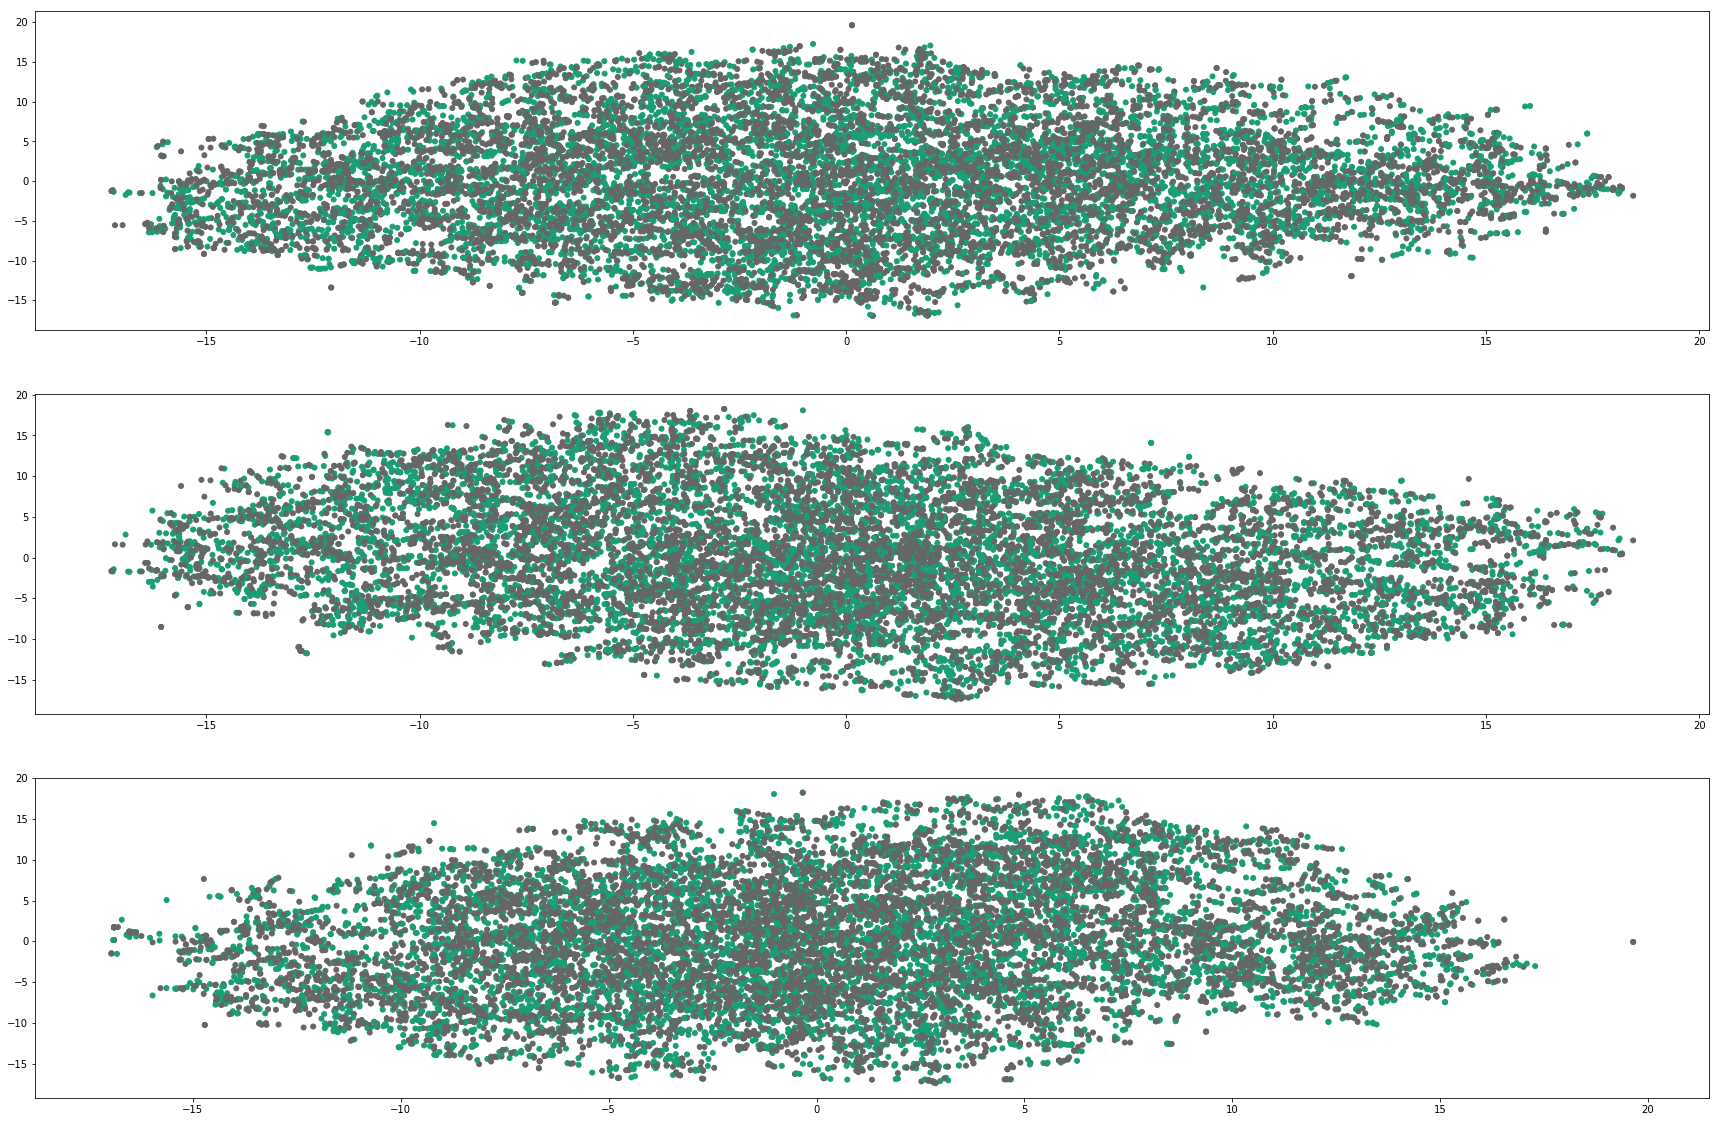

In [108]:
plot_tsne(X_tsne, 1)

# T - F

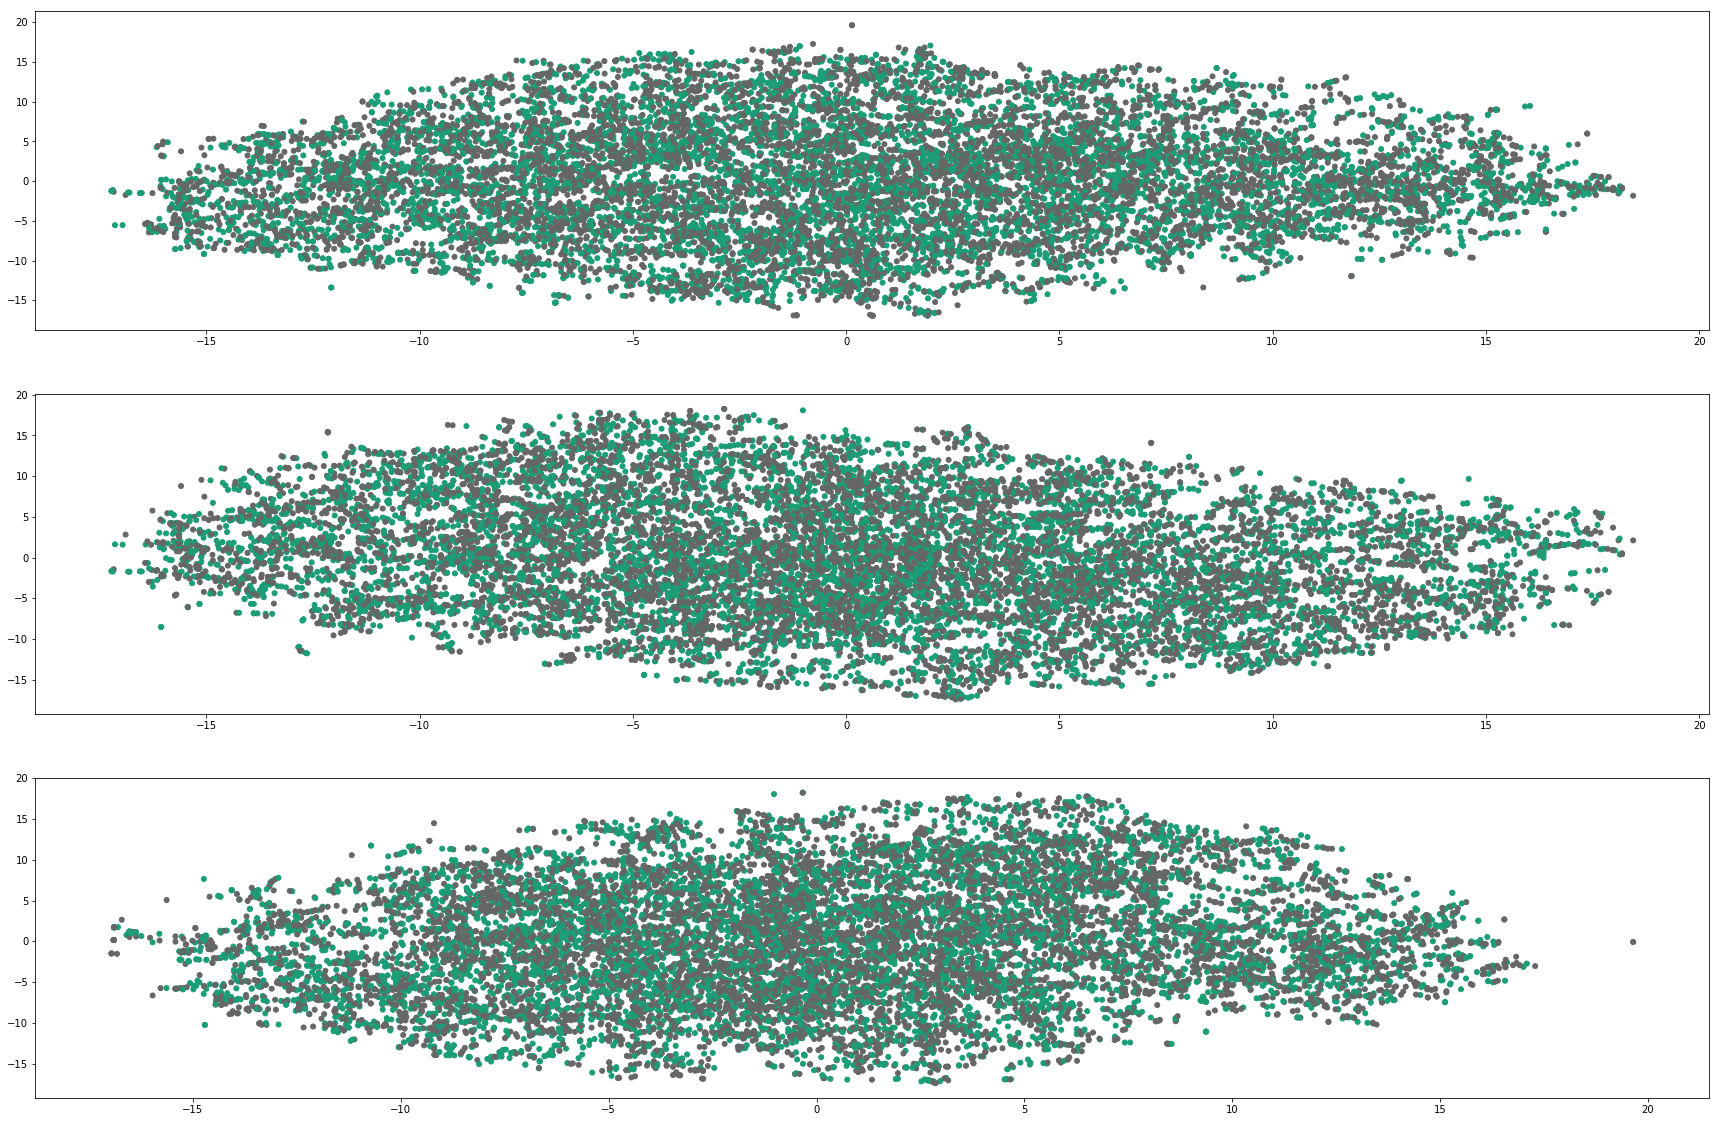

In [109]:
plot_tsne(X_tsne, 2)

# P - J

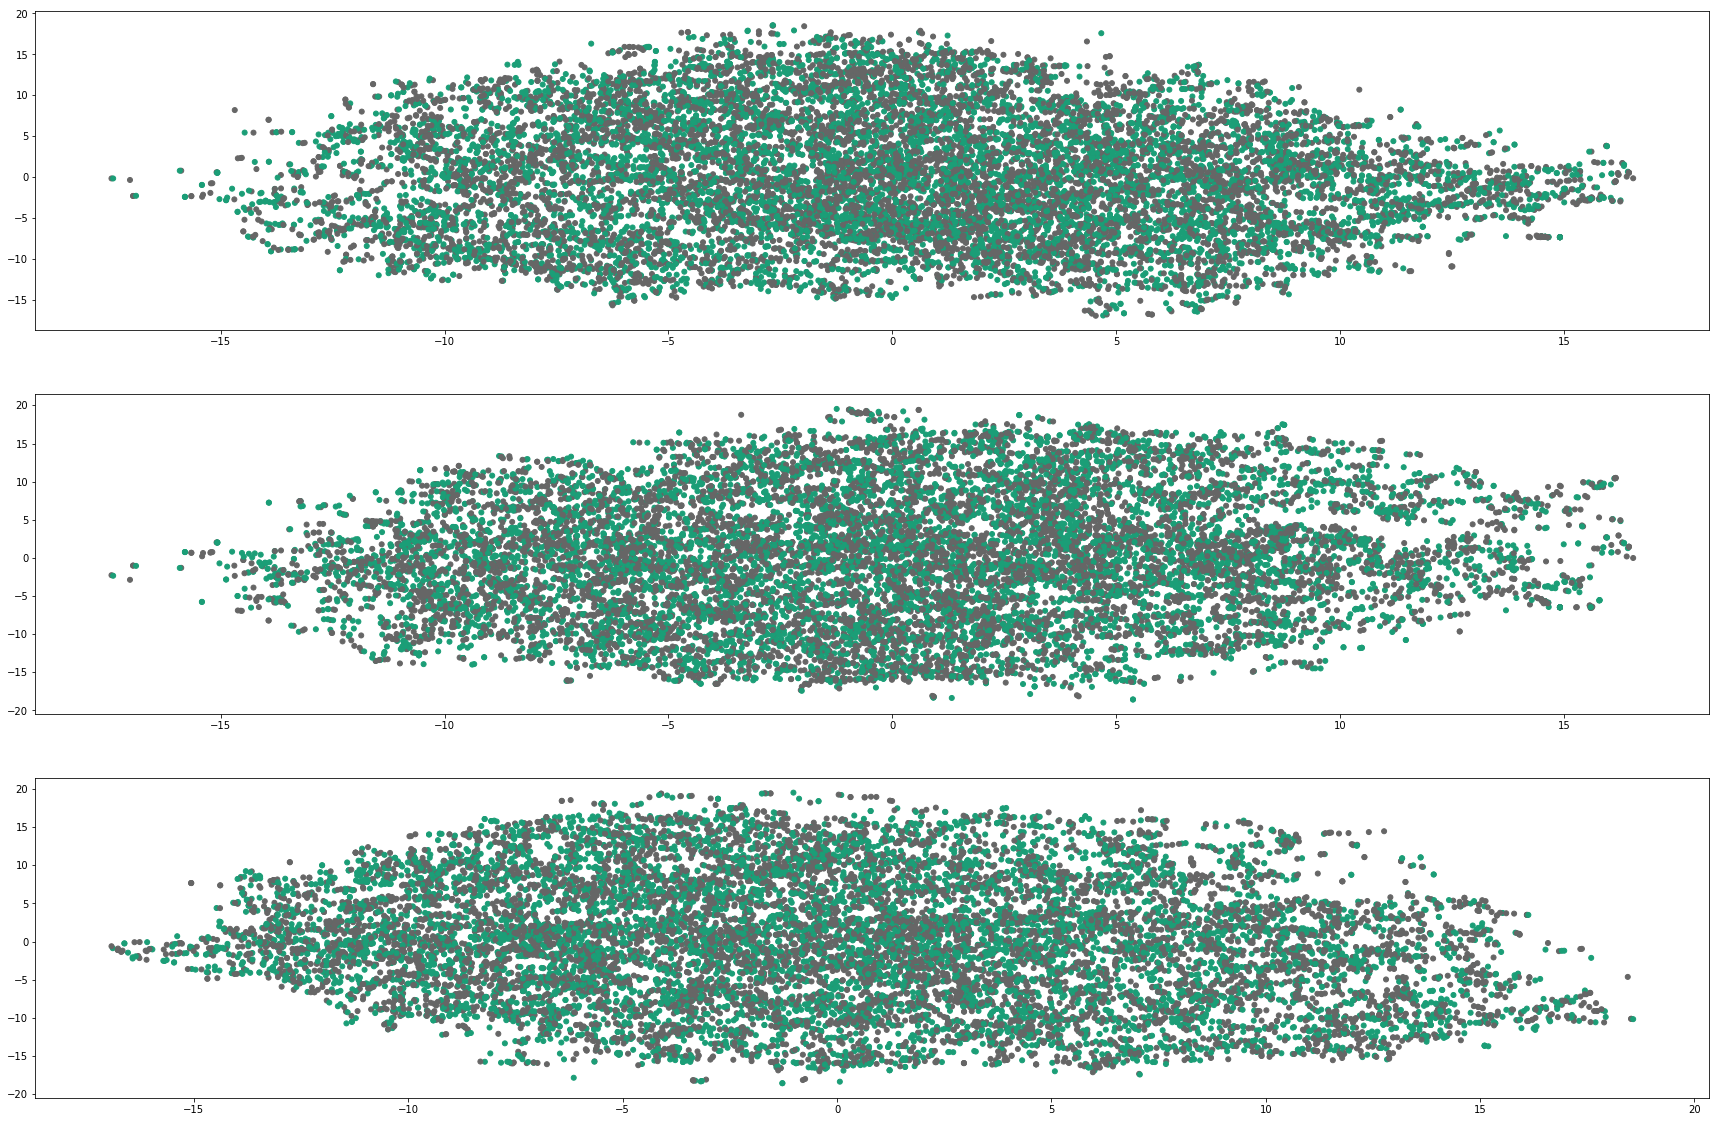

In [112]:
plot_tsne(X_tsne, 3)

# Understanding personalities with types of words they use 

In [177]:
def bag_of_words(group, type_label):
    posts = [t for t in group.get_group(type_label)['posts']]
    nlp = spacy.load('en')
    doc = nlp(''.join(posts))
    count_tags = Counter([w.pos_ for w in doc])
    return count_tags

def tags_pie_plot(count_tags):
    bag_of_tags = list(count_tags.keys())
    bag_of_tags_values = [count_tags.get(l) for l in bag_of_tags[:5]]
    
#     fig = figure()
    fig = plt.pie(bag_of_tags_values, labels = bag_of_tags[:5], autopct = '%1.1f%%', startangle = 140)
    
    return fig

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [124]:
types_grouped = df.groupby('type')

INTJ


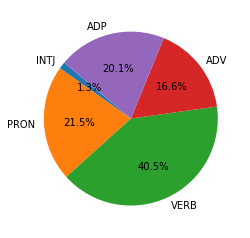

INTP


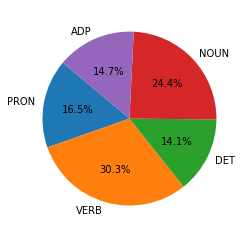

ISFP


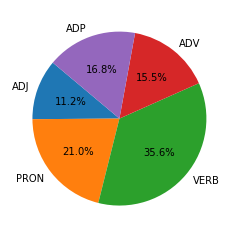

ENTJ


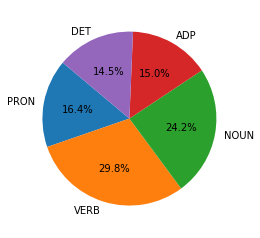

ISFJ


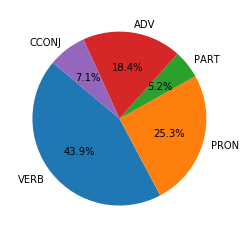

INFJ


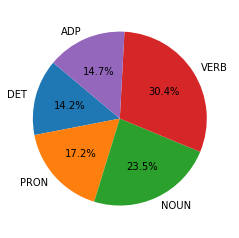

ESFJ


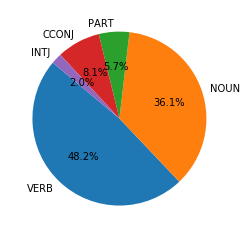

ENFJ


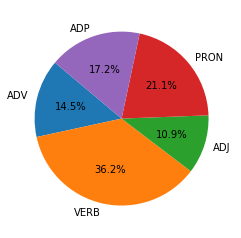

ESTP


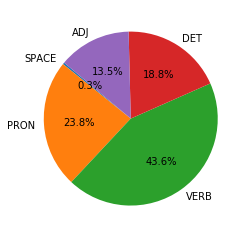

ENTP


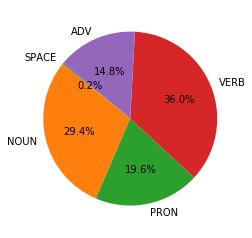

ESFP


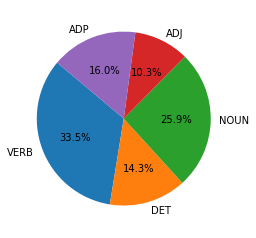

INFP


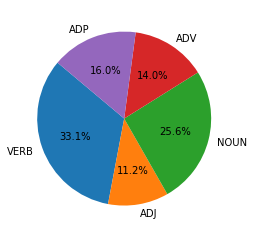

ISTJ


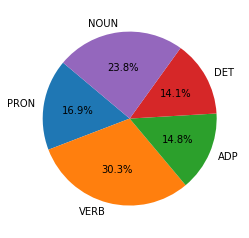

ENFP


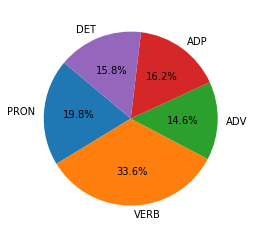

ESTJ


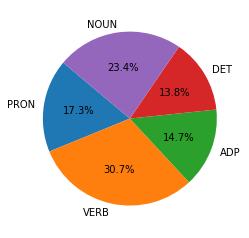

ISTP


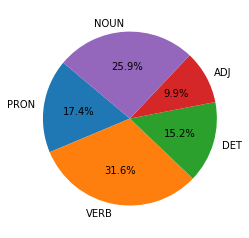

In [128]:
for l in labels:
    count_tags = bag_of_words(types_grouped, l)
    tags_pie_plot(count_tags)
    print(l)
    plt.show()

# Naive Bayes

Confusion matrix


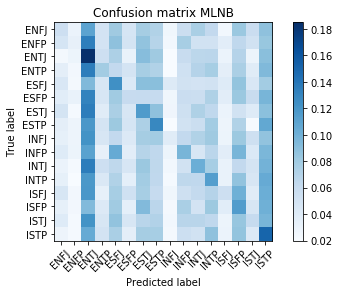

In [180]:

mlNB = MultinomialNB()
mlNB.fit(X_tfidf, list_personality)
preds = mlNB.predict(X_tfidf)
probs = np.ones((len(list_personality), 16))
probs = np.multiply(probs, mlNB.predict_proba(X_tfidf))
cnf_matrix = confusion_matrix(list_personality, preds)
np.set_printoptions(precision=2)
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lab_encoder.inverse_transform(range(16)), normalize=True,
                                          title=('Confusion matrix MLNB'))

# Adaboost

In [154]:
clf = AdaBoostClassifier()
multi_target_classifier = MultiOutputClassifier(clf, n_jobs=-1)
multi_target_classifier.fit(X_tfidf, list_personality_bin)

preds = multi_target_classifier.predict(X_tfidf)

preds_t = [translate_back(p) for p in preds]
vec1 = df.type ==  preds_t
for i in range(4):
    print("f1 score for %s:\n%s" % (titles[i],
                                    f1_score(np.array(list_personality_bin)[:,i], preds[:,i])))



f1 score for Extraversion (E) - Introversion (I):
0.5739761406961013
f1 score for Sensation (S) - INtuition (N):
0.5510088629077882
f1 score for Thinking (T) - Feeling (F):
0.5552956054378755
f1 score for Judgement (J) - Perception (P):
0.5427212178877261


## XGB

[0]	train-merror:0.900746	test-merror:0.930492
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.890858	test-merror:0.926326
[2]	train-merror:0.877519	test-merror:0.926326
[3]	train-merror:0.86791	test-merror:0.923674
[4]	train-merror:0.858022	test-merror:0.924811
[5]	train-merror:0.849813	test-merror:0.924242
[6]	train-merror:0.842071	test-merror:0.923295
[7]	train-merror:0.835355	test-merror:0.92178
[8]	train-merror:0.833116	test-merror:0.919886
[9]	train-merror:0.827519	test-merror:0.918182
[10]	train-merror:0.824347	test-merror:0.917803
[11]	train-merror:0.819776	test-merror:0.919318
[12]	train-merror:0.81278	test-merror:0.91875
[13]	train-merror:0.809142	test-merror:0.916856
[14]	train-merror:0.805597	test-merror:0.918182
[15]	train-merror:0.800466	test-merror:0.919318
[16]	train-merror:0.798041	test-merror:0.917235
[17]	train-merror:0.796269	test-merror:0.916288
[18]

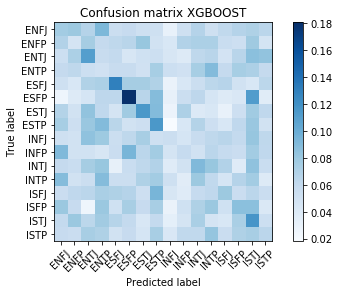

In [190]:


X_train, X_test, y_train, y_test = train_test_split(X_tfidf, list_personality, test_size=0.33, random_state=42)
probs = np.ones((len(y_test), 16))
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
# scale weight of positive examples
param['eta'] = 0.6
param['ntrees'] = 300
param['subsample'] = 0.93
param['max_depth'] = 2
param['silent'] = 1
param['n_jobs'] = 8
param['num_class'] = len(labels)
xgb_class = xgb.XGBClassifier(**param)


xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 30
bst = xgb.train(param, xg_train, num_round, watchlist, early_stopping_rounds=6)
preds = bst.predict(xg_test)
probs = np.multiply(probs, preds)
preds = np.array([np.argmax(prob) for prob in preds])

score = f1_score(y_test, preds, average='weighted')
print('XGBOOST' , score)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision=2)
# Plot confusion matrix
plt.figure()

plot_confusion_matrix(cnf_matrix, classes=lab_encoder.inverse_transform(range(16)), normalize=True,
                                          title=('Confusion matrix XGBOOST' ))
        

## Neural Networks

In [191]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, MaxPooling1D,Conv1D,Flatten, Input,concatenate, LSTM, Bidirectional, Input
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Model
from keras.preprocessing.text import Tokenizer

VALIDATION_SPLIT = 0.2
MAX_NB_WORDS = 20000


tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df.posts)
sequences = tokenizer.texts_to_sequences(df.posts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

ModuleNotFoundError: No module named 'keras'